In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Store Sales Forecasting with Linear Regression and XGBoost

# Forecast daily sales across Ecuadorian grocery stores using historical data and external signals

In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [4]:
#Loading the data and understanding each description

train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv') #training data which includes store_nbr, family, onpromotion and sales
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv') # has the same features as train, predicting sales with the dates from this file
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv') # Store metadata, city,state,type and cluster
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv') # no description
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv') #Daily oil price
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv') # holidays and events, with metadata

In [5]:
#Convert Dates(strings) to Datetime(object)

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

In [6]:
# Rename store type to avoid conflict
stores = stores.rename(columns={'type': 'store_type'})
train = train.merge(stores, on='store_nbr', how='left')

# Merge oil prices
train = train.merge(oil, on='date', how='left')
train['dcoilwtico'] = train['dcoilwtico'].ffill().bfill()

# Create holiday flag and merge
holidays['is_holiday'] = 1
holiday_flags = holidays[['date', 'is_holiday']].drop_duplicates()
train = train.merge(holiday_flags, on='date', how='left')
train['is_holiday'] = train['is_holiday'].fillna(0)

Calendar features help the regression capture **seasonality**, **weekly patterns** and **long-term trends** in sales.

Encoding categorical variables convert the text labels into numeric values so models like linear regression and XGBoost can use them.

In [7]:
# Calendar features
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

# Encode categorical variables
le_family = LabelEncoder()
le_store_type = LabelEncoder()
train['family_enc'] = le_family.fit_transform(train['family'])
train['store_type_enc'] = le_store_type.fit_transform(train['store_type'])

# Final feature list
features = ['day_of_week', 'month', 'year', 'onpromotion', 'family_enc', 'store_type_enc', 'dcoilwtico', 'is_holiday']
target = 'sales'

To align with the competition’s evaluation setup, we validate our model on the final 15 days of the training period. This simulates the real-world forecasting window and ensures our RMSLE reflects performance on the most recent unseen data

In [8]:
cutoff_date = pd.to_datetime('2017-07-31')

train_split = train[train['date'] <= cutoff_date].copy()
val_split = train[train['date'] > cutoff_date].copy()

X_train = train_split[features]
y_train = train_split[target]
X_val = val_split[features]
y_val = val_split[target]

# Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_val)
y_pred = np.maximum(0, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
print(f"RMSLE (Aug 1–15, 2017): {rmsle:.4f}")

RMSLE (Aug 1–15, 2017): 3.0054


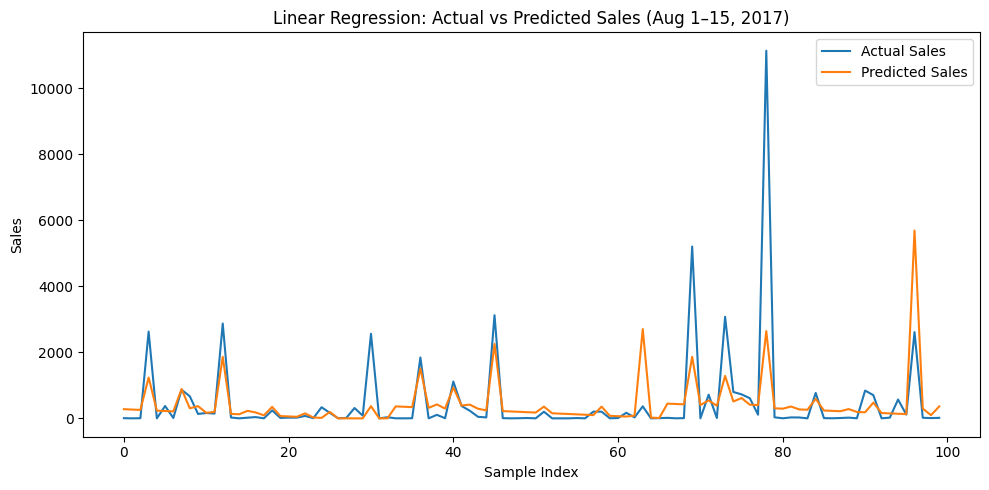

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(y_val.values[:100], label='Actual Sales')
plt.plot(y_pred[:100], label='Predicted Sales')
plt.title('Linear Regression: Actual vs Predicted Sales (Aug 1–15, 2017)')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

Established a baseline with linear regression, but struggles to account for complex interactions. Using a tree-based model like XGBoost seems appropiate to try and capture more complex interactions

In [10]:
# Calendar features
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['is_weekend'] = train['day_of_week'].isin([5, 6]).astype(int)

# National holiday flag
national_holidays = holidays[
    (holidays['locale'].str.strip() == 'National') &
    (holidays['transferred'] == False)
]
train['is_national_holiday'] = train['date'].isin(national_holidays['date']).astype(int)

# Encode categorical variables
for col in ['store_nbr', 'family']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

# Lag and rolling features
train['lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['lag_14'] = train.groupby(['store_nbr', 'family'])['sales'].shift(14)
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(7).mean())

# Store and family averages
train['store_avg_sales'] = train.groupby('store_nbr')['sales'].transform('mean')
train['family_avg_sales'] = train.groupby('family')['sales'].transform('mean')

In [11]:
cutoff_date = pd.to_datetime('2017-07-31')
train_split = train[train['date'] <= cutoff_date].copy()
val_split = train[train['date'] > cutoff_date].copy()

In [12]:
features = ['store_nbr', 'family', 'day_of_week', 'month', 'year',
            'is_weekend', 'is_national_holiday', 'dcoilwtico', 'onpromotion',
            'lag_7', 'lag_14', 'rolling_mean_7', 'store_avg_sales', 'family_avg_sales']

X_train = train_split[features]
y_train = train_split['sales']
X_val = val_split[features]
y_val = val_split['sales']

import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
# Predict on validation set
y_pred = model.predict(X_val)

# Clip predictions to avoid negative values
y_pred = np.maximum(0, y_pred)

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 0.5353


<Figure size 1000x600 with 0 Axes>

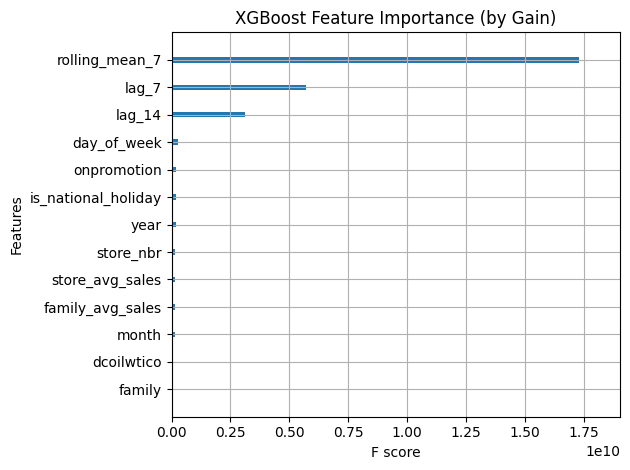

In [14]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=15, importance_type='gain', show_values=False)
plt.title('XGBoost Feature Importance (by Gain)')
plt.tight_layout()
plt.show() 

# Evaluation

Linear regression RMSLE: 3.0054

XGBoost RMSLE: 0.5353

XGBoost outperforms due to its ability to model nonlinear and temporal patterns. Next steps could be to try a hybrid model that uses linear regression and a tree based model together 